In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from IPython.display import display, Latex

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Time to get your hands dirty. The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). 

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x1fd5f766a00>)

I'll take this as an opportunity to introduce `pandas` and `seaborn`, which are popular python packages. The are similar to `numpy` and `matplotlib`, but newer. I personally prefer my good old numpy, but these are *very* popular, so here is something you can do with them. 

In [4]:
import pandas as pd
#pd.set_option('display.max_rows', None)
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


There are 6 star types that are encoded in the *'Star type'* column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


We've seen this already last time. It is often good practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:

![](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

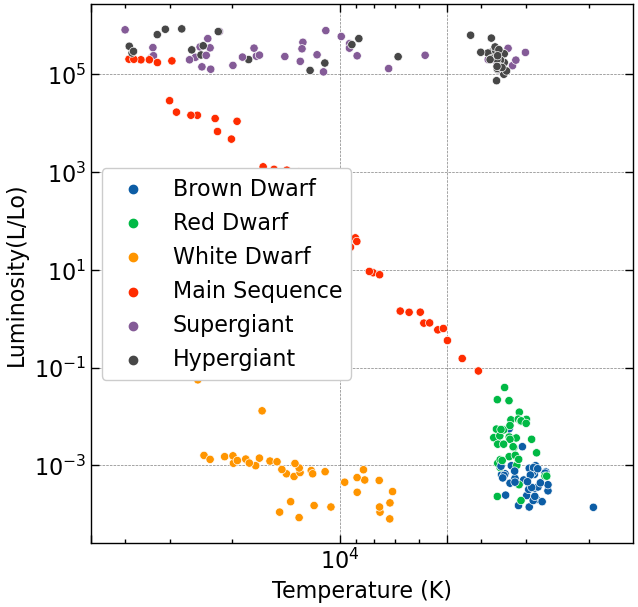

In [6]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposa (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two. 
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

**This is actually a very important lesson in machine learning**: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is [the usual machine-learning approach](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) standardize your data such that each dimension has mean=0 and variance=1. 
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?



### For later: come back to this assignment after lecture 20
- Now run a supervised classification algorithm on this dataset. 
- Can you predict the stellar type? How well? Careful with overfitting of course.

# Code

## 1) Exploring the dataset

### Functions

In [7]:
# Function recycled from the previous exercise

# A function to compute the KDE by using an automatically-estimated bandwidth
def KDE_Sklearn(data, x_dense, kernel="epanechnikov"):
    bandwidth = estimate_bandwidth(data, n_jobs=int(mp.cpu_count()/2))
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data)
    log_pdf = kde_skl.score_samples(x_dense) # Sklearn returns log(density)

    return np.exp(log_pdf), bandwidth


# A function to plot the KDE of 1D data, and also:
# 1) fit the data with a gaussian mixture and plot the results, if requested;
# 2) compare the data with the respective uncertainties, if the latter are present.
def Plot1D(data, data_err=None, x_label='', y_label='', x_min=None, x_max=None, 
           GaussMix_n_components=None, weights_init=None, means_init=None):
    if x_min==None: x_min = np.min(data)
    if x_max==None: x_max = np.max(data)
    
    if data_err is None:
        plt.rcParams['figure.figsize'] = [8 , 8]
        fig, axes = plt.subplots(1, 1)
        ax = axes
    else:  
        plt.rcParams['figure.figsize'] = [16 , 8]
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]

    x_dense = np.linspace(x_min, x_max, 1000)
    KDE, bandwidth = KDE_Sklearn(data[:, np.newaxis], x_dense[:, np.newaxis], kernel="epanechnikov") 
    ax.plot(x_dense, KDE, color='red', label=f'KDE (bandwidth={bandwidth:.3f})') 
    
    ax.set_xlabel(x_label)
    ax.set_ylabel('pdf')
    ax.set_xlim(0.99*x_min, 1.01*x_max)
    ax.set_ylim(top=1.1*np.max(KDE))
    ax.legend(loc='upper left', fontsize=13)

    # Executed only if the uncertainties on the data are passed to the function
    if data_err is not None:
        ax = axes[1]
        ax.scatter(data, data_err, s=15, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5)
        ax.plot([x_min, x_max], [x_min, x_max], color='red', ls='--')
        ax.set_ylim(0.99*x_min, 1.01*x_max)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    
    return fig, axes

### 1.1) Temperature

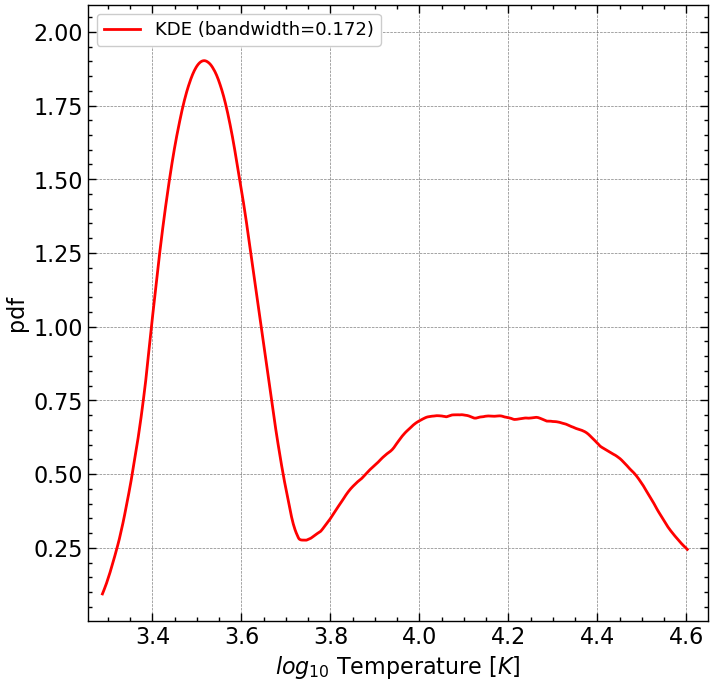

In [8]:
fig, axes = Plot1D(np.log10(np.array(df_stars['Temperature (K)'])), x_label='$log_{10}$ Temperature $[K]$')

### 1.2) Luminosity

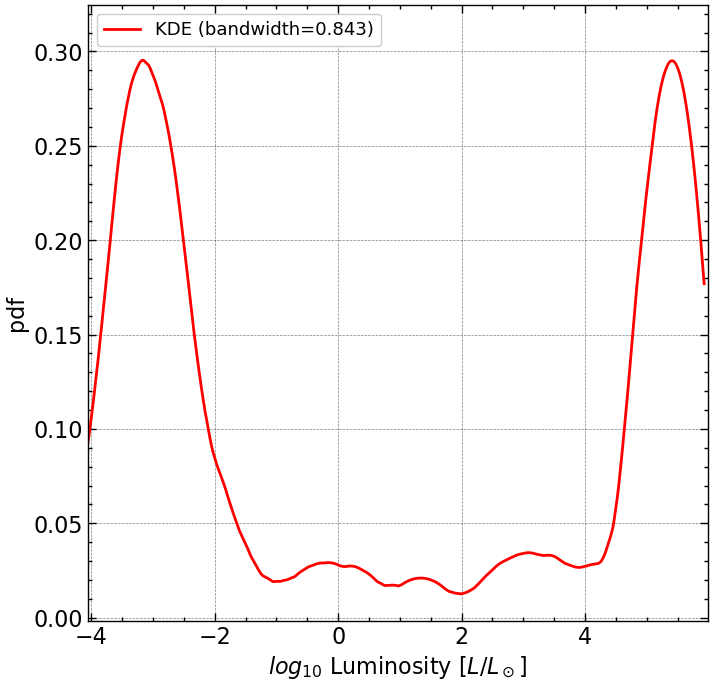

In [9]:
fig, axes = Plot1D(np.log10(np.array(df_stars['Luminosity(L/Lo)'])), x_label='$log_{10}$ Luminosity $[L/L_\odot]$')

### 1.3) Radius

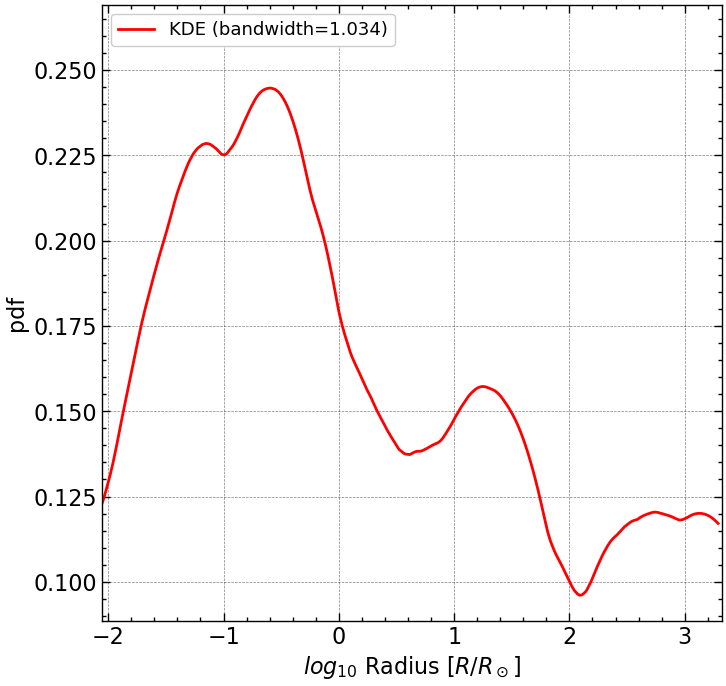

In [10]:
fig, axes = Plot1D(np.log10(np.array(df_stars['Radius(R/Ro)'])), x_label='$log_{10}$ Radius $[R/R_\odot]$')

### 1.4) Absolute magnitude

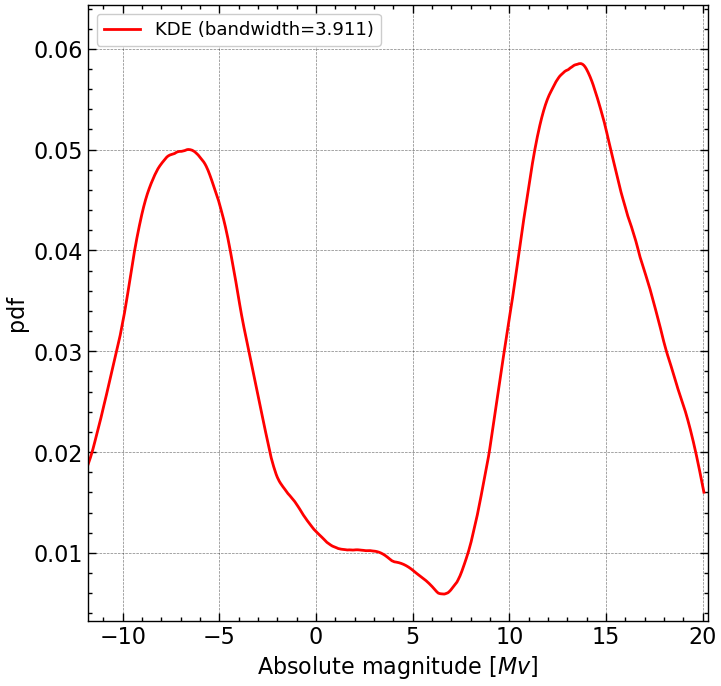

In [11]:
fig, axes = Plot1D(np.array(df_stars['Absolute magnitude(Mv)']), x_label='Absolute magnitude $[Mv]$')

## 2) Principal Component Analysis

### Functions

In [12]:
def PCA_pipeline(X, n_components=None, classes=df_stars['Star type'], X_names=['Temperature', 'Luminosity', 'Radius', 'Absolute_Magnitude'], n_clusters=1):
    if n_components is None: n_components=len(X[0,:])
    
    pca = PCA(n_components=n_components)
    pca.fit(X) 

    eigenvalues = pca.transform(X) # compute the subspace projection of X, n_components eigenvalues for each of the N samples
    eigenvectors = pca.components_ # (n_components X n_features) matrix of components, multiply each by respective eigenvalue to reconstruct
    
    
    # Projection of the components
    print("Projection of the components:")
    for component in pca.components_:
        print(" + ".join("%.3f x %s" % (value, name) for value, name in zip(component, X_names)))
    print('\n')
    
    
    # Explained variance ratio
    evr = pca.explained_variance_ratio_ 
    print(f'Explained variance ratio = {evr}')
    print(f'The first component explains {evr[0]:.3f} of the variance in the data.')
    print(f'The second component explains {evr[1]:.3f} of the variance in the data.')
    print(f'In total, two components explain {evr[0]+evr[1]:.3f} of the variance in the data.')
    
    
    # Scatter plot
    plt.rcParams['figure.figsize'] = [20 , 9]
    fig, axes = plt.subplots(1, 2)
    ax = axes[0]
    ax.set_title('Principal components with true labels')

    for type in np.unique(classes):
        mask = classes==type
        ax.scatter(eigenvalues[mask][:, 0], eigenvalues[mask][:, 1], alpha=0.6, label=class_names[type])

    ax.set_xlabel('Principal_components[0]')
    ax.set_ylabel('Principal_components[1]')
    ax.legend(fontsize=13);
    
    
    # Clustering with KMeans
    clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, tol=1e-9, verbose=False)
    clf.fit(eigenvalues)
    labels = clf.predict(eigenvalues)     

    ax = axes[1]
    ax.set_title('Clustering with KMeans')
    
    for i in range(n_clusters):
        ax.scatter(eigenvalues[labels==i,0], eigenvalues[labels==i,1], alpha=0.5, label=f'Cluster {i+1}')
        
    ax.set_xlabel('Principal_components[0]')
    ax.set_ylabel('Principal_components[1]')
    ax.legend(fontsize=13);
    
    
    return pca, eigenvalues, eigenvectors, evr, labels, fig

### 2.1) First attempt

Projection of the components:
0.021 x Temperature + 1.000 x Luminosity + 0.002 x Radius + -0.000 x Absolute_Magnitude
1.000 x Temperature + -0.021 x Luminosity + -0.009 x Radius + -0.000 x Absolute_Magnitude
0.009 x Temperature + -0.002 x Luminosity + 1.000 x Radius + -0.008 x Absolute_Magnitude
0.000 x Temperature + 0.000 x Luminosity + 0.008 x Radius + 1.000 x Absolute_Magnitude


Explained variance ratio = [9.97606313e-01 2.38789920e-03 5.78677260e-06 1.34274189e-09]
The first component explains 0.998 of the variance in the data.
The second component explains 0.002 of the variance in the data.
In total, two components explain 1.000 of the variance in the data.


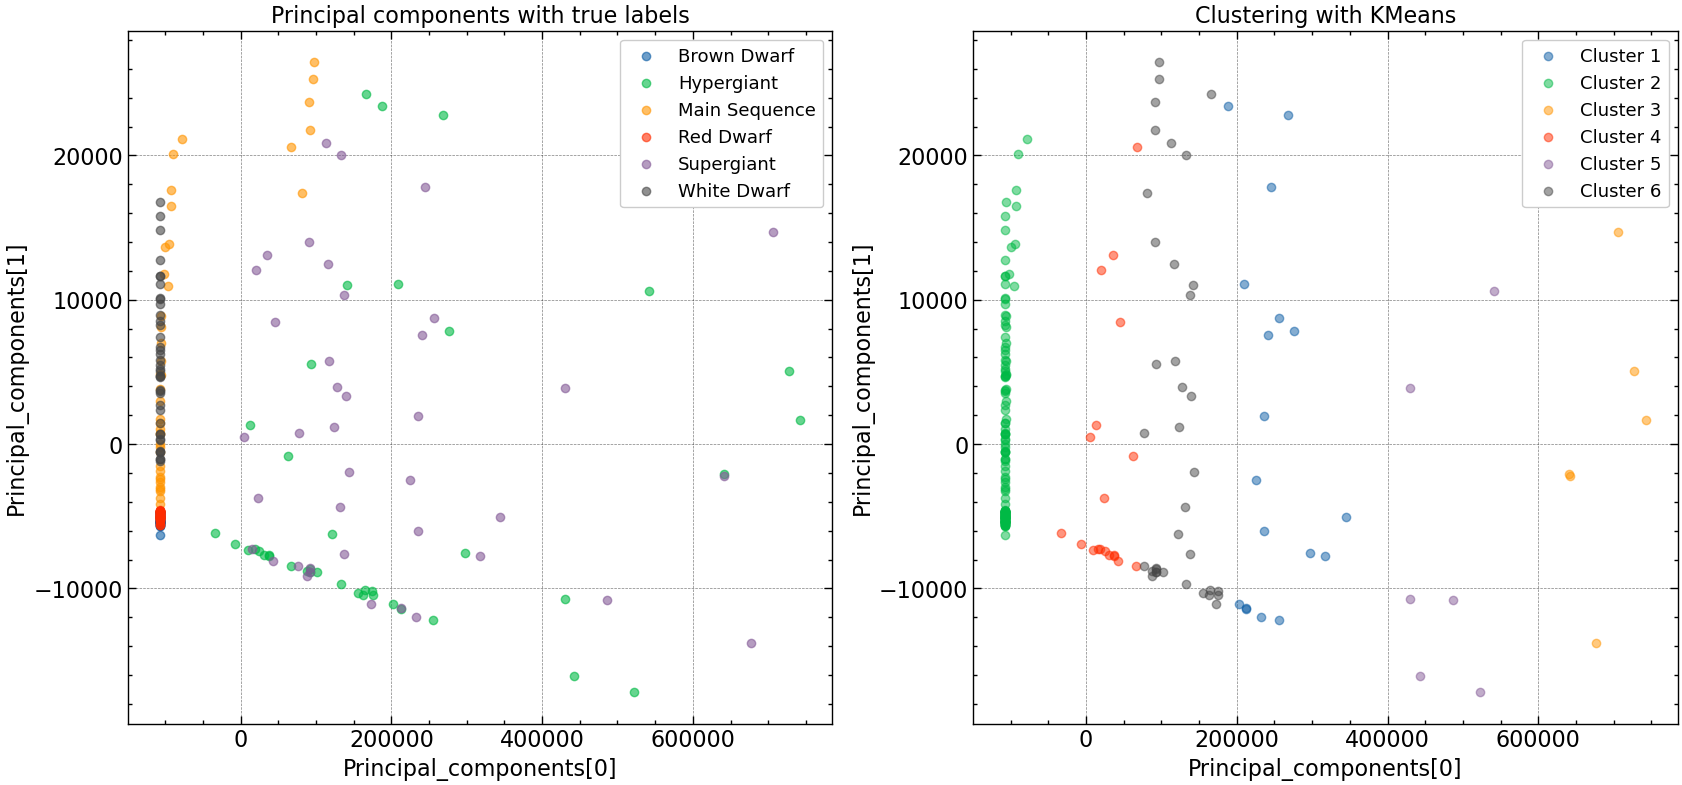

In [13]:
X = np.array([np.array(df_stars['Temperature (K)']), 
              np.array(df_stars['Luminosity(L/Lo)']), 
              np.array(df_stars['Radius(R/Ro)']), 
              np.array(df_stars['Absolute magnitude(Mv)'])]).T

pca, eigenvalues, eigenvectors, evr, labels, fig = PCA_pipeline(X, n_components=4, n_clusters=len(class_names))

The six different populations are mixed together, and thus the `KMeans` clustering fails completely.

### 2.2) Second attempt: log10-scale

Projection of the components:
0.014 x Temperature + 0.344 x Luminosity + 0.139 x Radius + -0.929 x Absolute_Magnitude
0.124 x Temperature + -0.764 x Luminosity + -0.522 x Radius + -0.359 x Absolute_Magnitude
0.356 x Temperature + 0.536 x Luminosity + -0.760 x Radius + 0.090 x Absolute_Magnitude
0.926 x Temperature + -0.109 x Luminosity + 0.360 x Radius + 0.028 x Absolute_Magnitude


Explained variance ratio = [9.90581688e-01 5.61418105e-03 3.39381443e-03 4.10316578e-04]
The first component explains 0.991 of the variance in the data.
The second component explains 0.006 of the variance in the data.
In total, two components explain 0.996 of the variance in the data.


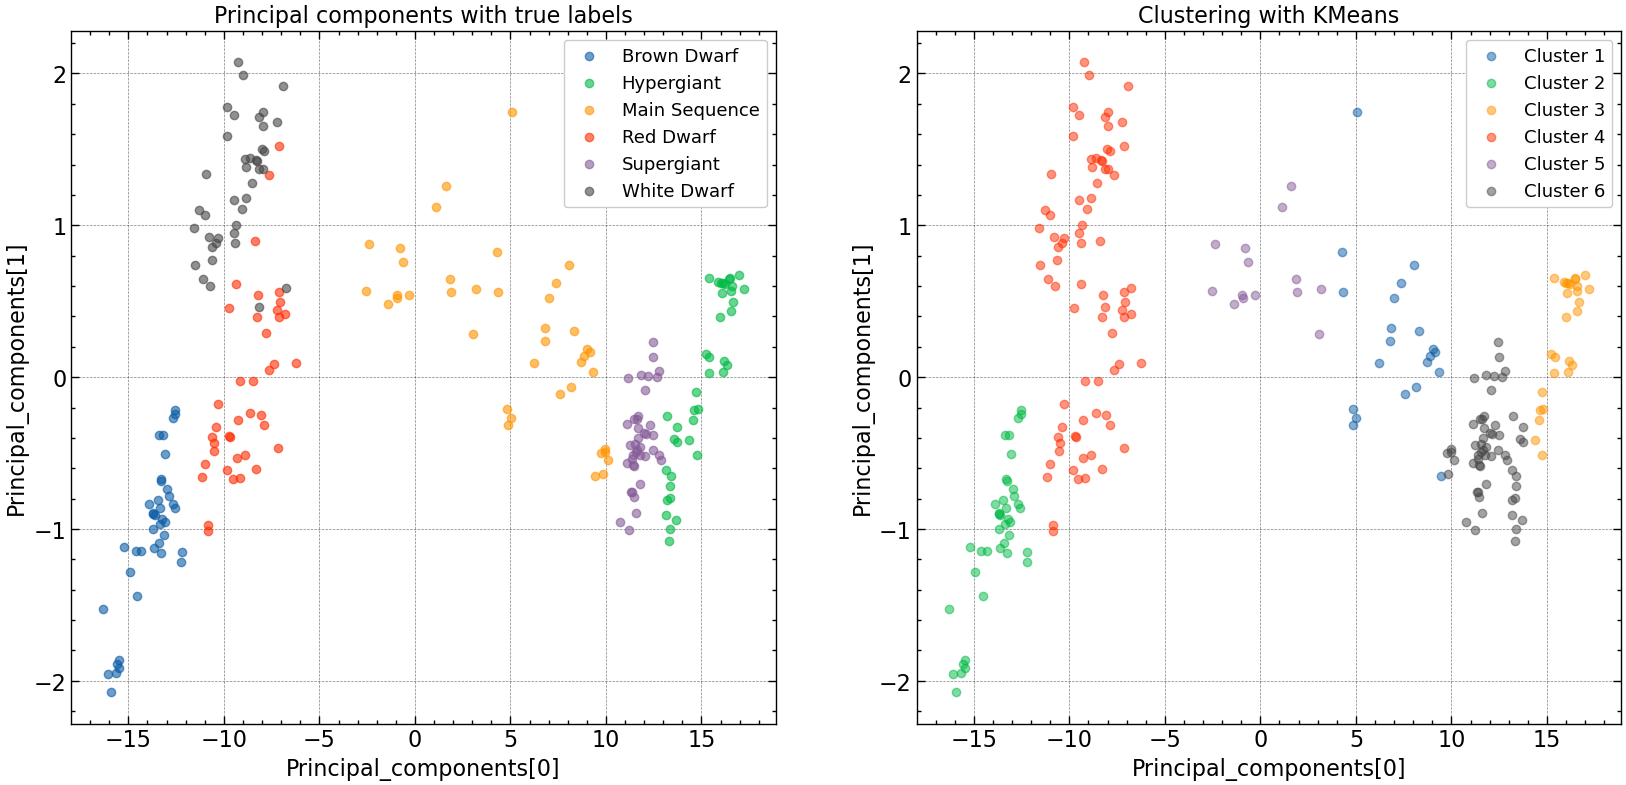

In [14]:
X = np.array([np.log10(np.array(df_stars['Temperature (K)'])), 
              np.log10(np.array(df_stars['Luminosity(L/Lo)'])), 
              np.log10(np.array(df_stars['Radius(R/Ro)'])), 
              np.array(df_stars['Absolute magnitude(Mv)'])]).T

pca, eigenvalues, eigenvectors, evr, labels, fig = PCA_pipeline(X, n_components=4, n_clusters=len(class_names))

Now the six different populations are definitely more distinguishable, even though white and red dwarfs are still a bit mixed together.\
`KMeans` flawlessly identifies the brown dwarfs, but it puts white and red dwarfs into the same cluster, splitting the main sequence instead.

Let's see if we can improve this further by employing a classical machine-learning reshaping.

### 2.3) Third attempt: rescale in $\mu_i=0$, $\sigma_i=1$

Projection of the components:
0.350 x Temperature + 0.559 x Luminosity + 0.475 x Radius + -0.582 x Absolute_Magnitude
0.822 x Temperature + 0.005 x Luminosity + -0.569 x Radius + 0.035 x Absolute_Magnitude
-0.376 x Temperature + 0.755 x Luminosity + -0.533 x Radius + 0.064 x Absolute_Magnitude
0.247 x Temperature + 0.342 x Luminosity + 0.408 x Radius + 0.810 x Absolute_Magnitude


Explained variance ratio = [0.60357391 0.23500784 0.09329645 0.0681218 ]
The first component explains 0.604 of the variance in the data.
The second component explains 0.235 of the variance in the data.
In total, two components explain 0.839 of the variance in the data.


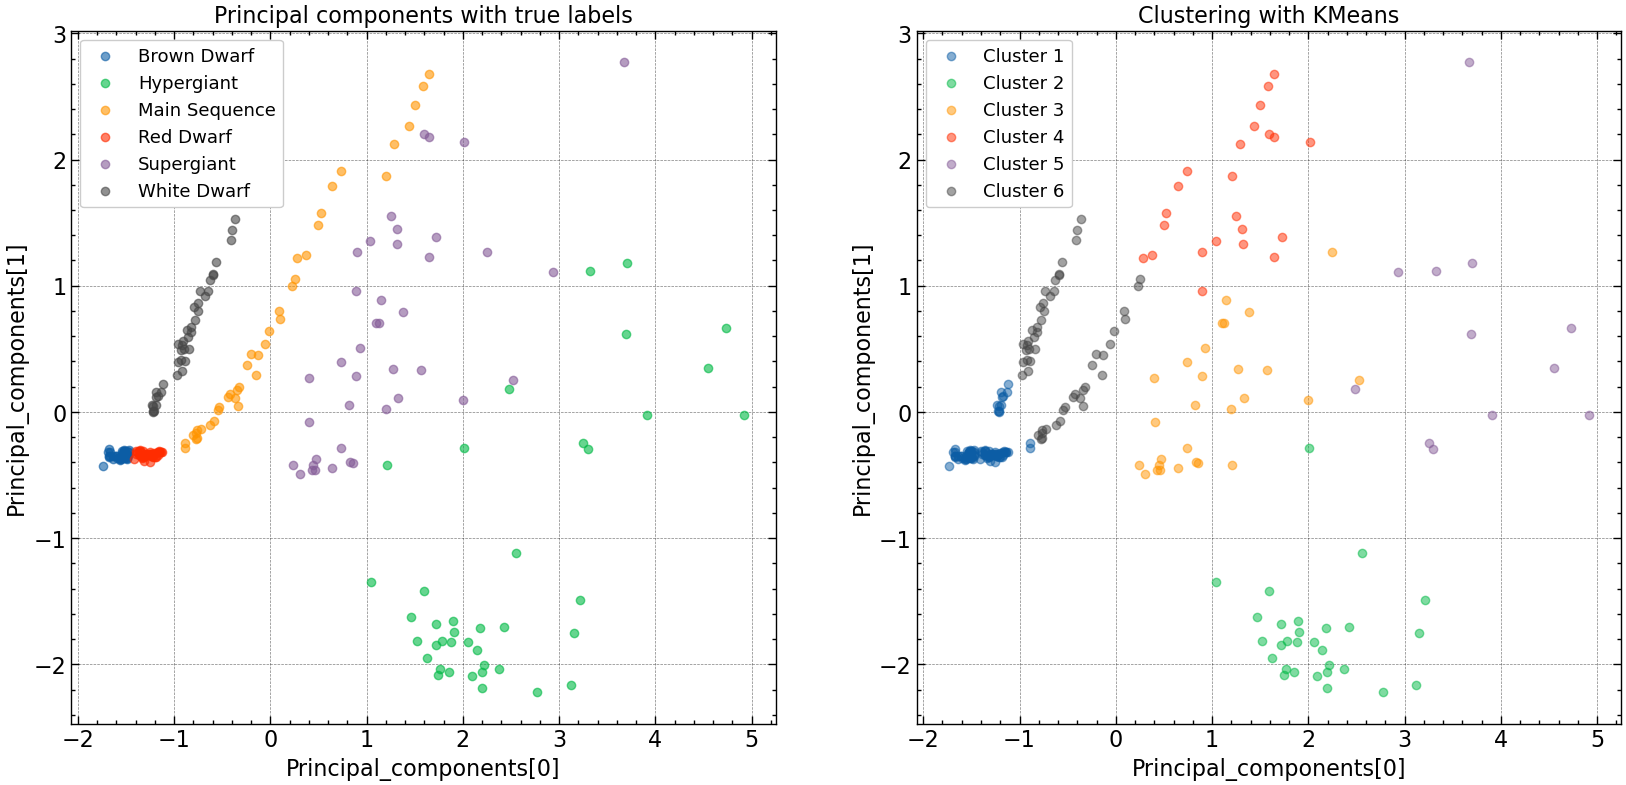

In [15]:
from sklearn import preprocessing

X = np.array([np.array(df_stars['Temperature (K)']), 
              np.array(df_stars['Luminosity(L/Lo)']), 
              np.array(df_stars['Radius(R/Ro)']), 
              np.array(df_stars['Absolute magnitude(Mv)'])]).T

scaler = preprocessing.StandardScaler()
pca, eigenvalues, eigenvectors, evr, labels, fig = PCA_pipeline(scaler.fit_transform(X), n_components=4, n_clusters=len(class_names))

The classes are well-separated, but `KMeans` is still quite confused...

### 2.4) Fourth attempt: log10-scale + rescale in $\mu_i=0$, $\sigma_i=1$

Projection of the components:
0.282 x Temperature + 0.566 x Luminosity + 0.529 x Radius + -0.566 x Absolute_Magnitude
0.926 x Temperature + -0.063 x Luminosity + -0.368 x Radius + 0.054 x Absolute_Magnitude
0.251 x Temperature + -0.354 x Luminosity + 0.761 x Radius + 0.482 x Absolute_Magnitude
0.018 x Temperature + -0.742 x Luminosity + 0.072 x Radius + -0.667 x Absolute_Magnitude


Explained variance ratio = [0.76162934 0.22012559 0.01245219 0.00579288]
The first component explains 0.762 of the variance in the data.
The second component explains 0.220 of the variance in the data.
In total, two components explain 0.982 of the variance in the data.


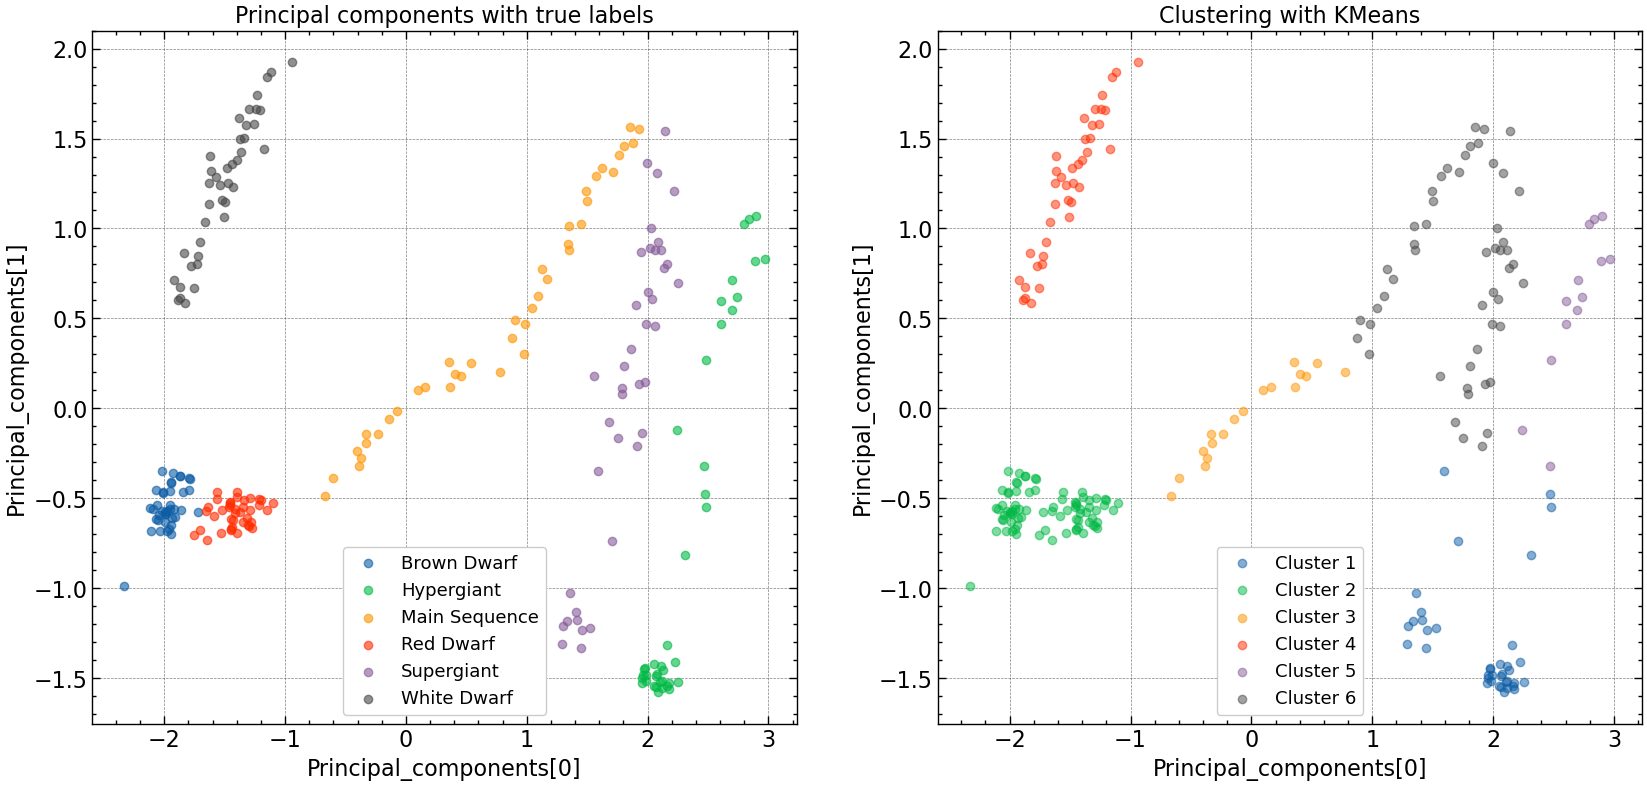

In [16]:
from sklearn import preprocessing

X = np.array([np.log10(np.array(df_stars['Temperature (K)'])), 
              np.log10(np.array(df_stars['Luminosity(L/Lo)'])), 
              np.log10(np.array(df_stars['Radius(R/Ro)'])), 
              np.array(df_stars['Absolute magnitude(Mv)'])]).T

scaler = preprocessing.StandardScaler()
pca, eigenvalues, eigenvectors, evr, labels, fig = PCA_pipeline(scaler.fit_transform(X), n_components=4, n_clusters=len(class_names))

Even though `KMeans` is still quite confused, this appears to be the best dimensionality-reduction so far, since each population is restricted to a strip.